In [1]:
import numpy as np
import pandas as pd
import torch
import os
import time_series_explainer.ts_explainer as ts_explainer
import matplotlib.pyplot as plt
import lightgbm

In [2]:
# Import sklearn models and tools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF, DotProduct

In [3]:
DIR = "./ucsd"

giga_batch = np.load(os.path.join(DIR, "giga_batch.npy"))
y_giga_batch = np.load(os.path.join(DIR, "giga_batch_y.npy"))
columns_giga_batch = np.load(os.path.join(DIR, "giga_batch_columns_name.npy"), allow_pickle=True)

In [4]:
class TimeSeriesModel:
    def __init__(self, model):
        self.model = model

    def fit(self, X: np.array, y: np.array):
        self.size = min([arr.shape[1] for arr in X])

        self.model.fit([arr[:, : self.size].ravel() for arr in X], y)

    def predict(self, X: np.array):
        if isinstance(X, list) or len(X.shape) == 3:
            return self.model.predict([arr[:, : self.size].ravel() for arr in X])
        else:
            return self.model.predict(X.ravel()[None, :])

    def predict_proba(self, X):
        if isinstance(X, list) or len(X.shape) == 3:
            return self.model.predict_proba([arr[:, : self.size].ravel() for arr in X])
        else:
            return self.model.predict_proba(X.ravel()[None, :])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(giga_batch, y_giga_batch, test_size=0.2, random_state=420)

In [6]:
X_train.shape, X_test.shape

((2944, 6, 1000), (736, 6, 1000))

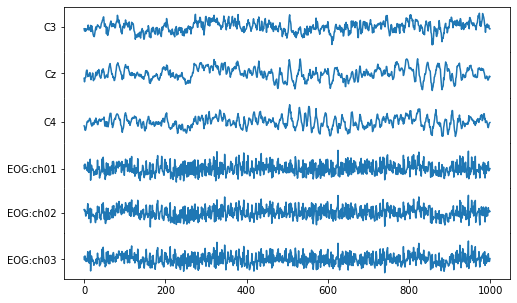

In [7]:
fig, _ = ts_explainer.plot_eeg(X_train[0], features_name=columns_giga_batch, figsize=(8, 5))
fig.savefig('./reports/diploma/figures/motor_ts.png', bbox_inches='tight', pad_inches=0.2)
plt.show()

In [8]:
model = TimeSeriesModel(LogisticRegression(C=0.000006, max_iter=100))
model.fit(X_train, y_train)
f1_score(y_test, model.predict(X_test)), accuracy_score(y_test, model.predict(X_test))

(0.7287899860917941, 0.7350543478260869)

In [21]:
model = TimeSeriesModel(lightgbm.LGBMClassifier(learning_rate=0.05, n_estimators=300))
model.fit(X_train, y_train)
f1_score(y_test, model.predict(X_test)), accuracy_score(y_test, model.predict(X_test))

(0.7262569832402236, 0.7336956521739131)

In [22]:
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm

In [23]:
num_slices_range = np.array([30])
num_samples = 5000

explainers = [
    ts_explainer.ShapTimeSeriesExplainer(model.predict_proba, data=X_test, replacement_method="dataset_mean"),
    ts_explainer.LimeTimeSeriesExplainer(model.predict_proba, data=X_test, replacement_method="dataset_mean")
]
replacement_methods = ["zeros", "reverse", "mean", "swap", "dataset_mean"]

In [24]:
with tqdm(total=len(explainers) * X_test.shape[0]) as pbar:
    for explainer_name, explainer in list(zip(["SHAP", "LIME"], explainers)):
        new_X_test = dict(zip(replacement_methods, [np.zeros_like(X_test)
                                                    for i in range(len(replacement_methods))]))
        
        for i in range(X_test.shape[0]):
            inst = X_test[i]
            inst_label = y_test[i]
            
            functor = lambda num_slices: explainer.explain_instance(
                                        inst, 
                                        labels=[0,1],
                                        num_features=num_slices, 
                                        num_samples=num_samples, 
                                        num_slices=num_slices
                                        )
            cumulative_explanation = ts_explainer.cumulative_explanation(inst, 
                                                                     inst_label, 
                                                                     functor, 
                                                                     num_slices_range
                                                                     )
            explanations = cumulative_explanation[0]
            
            for replacement_method in replacement_methods:
                new_instance = ts_explainer.evaluate_explanation(inst,
                                                                explanations, 
                                                                max(num_slices_range),
                                                                replacement_method=replacement_method,
                                                                data = X_test,
                                                                quantile=0.7
                                                                )
                new_X_test[replacement_method][i] = new_instance
                
            pbar.update(1)
                
        for replacement_method in replacement_methods:
            f1_old = f1_score(y_test, model.predict(X_test))
            f1_new = f1_score(y_test, model.predict(new_X_test[replacement_method]))
            print(f"{explainer_name}, {replacement_method}, f1: {f1_old - f1_new}")
            

  0%|          | 0/1472 [00:00<?, ?it/s]

SHAP, zeros, f1: 0.5453784302686473
SHAP, reverse, f1: 0.49292364990689025
SHAP, mean, f1: 0.497685554668795
SHAP, swap, f1: 0.4159121556540167
SHAP, dataset_mean, f1: 0.6391783315548303
LIME, zeros, f1: 0.5962179715367125
LIME, reverse, f1: 0.5098390727924624
LIME, mean, f1: 0.5284250049204404
LIME, swap, f1: 0.4157674727507131
LIME, dataset_mean, f1: 0.6869862960031969


In [18]:
for replacement_method in replacement_methods:
        new_X_test = np.empty_like(X_test)
        for i in range(X_test.shape[0]):
            inst = X_test[i]
            inst_label = y_test[i]
            explanations = list(zip(np.arange(30), np.random.rand(max(num_slices_range))))
            new_instance = ts_explainer.evaluate_explanation(inst,
                                                            explanations, 
                                                            max(num_slices_range),
                                                            replacement_method=replacement_method,
                                                            data = X_test
                                                            )
            new_X_test[i] = new_instance
            
        f1_old = f1_score(y_test, model.predict(X_test))
        f1_new = f1_score(y_test, model.predict(new_X_test))
        print(f"Random, {replacement_method}, f1: {f1_old - f1_new}")

Random, zeros, f1: 0.0173053922542592
Random, reverse, f1: 0.20927046657227455
Random, mean, f1: 0.019388276690084694
Random, swap, f1: 0.028650516077847188
Random, dataset_mean, f1: 0.02555510564172392
